# Car price prediction

The customer is a used car sales service that develops an application to attract new customers. 

**The main goal of the project** is to develop a model to predict the market value of a car. We have historical data at our disposal including vehicle specifications, equipment and prices.

**Course of Work**:
1. [Data preprocessing](#preprocessing)
2. [Model selection](#models)
3. [Final testing](#test)

**The ML algorithms** under study are: **Random Forest*, *LightGBM* \
**Quality assessment metric**: RMSE

Additionally, it is important for the customer to evaluate the training time and prediction speed of the model.

<a id='preprocessing'></a>
## Data preprocessing

### Data loading

In [1]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
# data
data = pd.read_csv('/datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Data description
There are a total of 15 columns and just over 350k rows in the dataset.

**Attributes**.
- `DateCrawled` - date when the questionnaire was downloaded from the database
- `VehicleType` - car body type
- `RegistrationYear` - vehicle registration year
- `Gearbox` - type of gearbox
- `Power` - power (hp)
- `Model` - car model
- `Kilometer` - mileage (km)
- `RegistrationMonth` - vehicle registration month
- `FuelType` - fuel type
- `Brand` - car make
- `Repaired` - whether the car has been repaired or not
- `DateCreated` - date of questionnaire creation
- `NumberOfPictures` - number of photos of the car
- `PostalCode` - postal code of questionnaire owner (user)
- `LastSeen` - date of the last activity of the user

**Target attribute**
- `Price` - price (euro)

In [4]:
# missing values
data.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

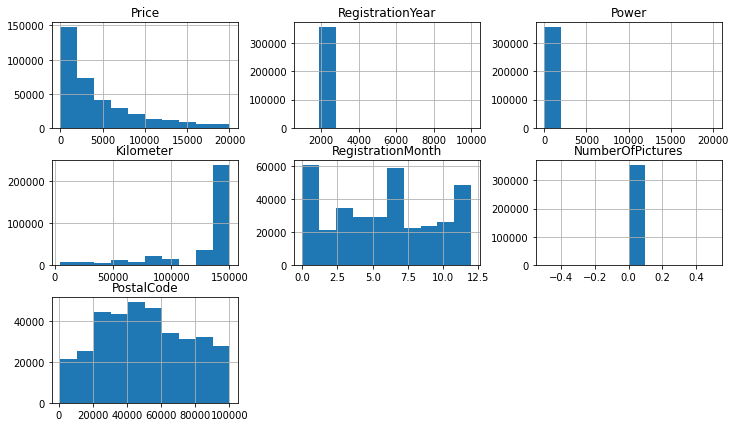

In [5]:
data.hist(figsize=(12, 7))
plt.show()

Gaps are observed in 5 categorical columns - `VehicleType`, `Gearbox`, `FuelType`, `Model`, `Repaired`. These should be eliminated or filled in with suitable values. Also, some numeric should be checked for abnormal values. These include: `RegistrationYear`, `Power`, `NumberOfPictures`.

### Data preprocessing

In the dataset there are 3 columns with dates + column with postal code, related to the questionnaire itself or to the user and not affecting the value of the car itself, i.e. useless for further training. Let's delete everything except the column with the date of questionnaire upload. It will be needed later to check the correctness of the registration year values.

In [6]:
data.drop(columns=['DateCreated', 'LastSeen', 'PostalCode'], inplace=True)

In [7]:
# unique values in the column with picture info
data['NumberOfPictures'].unique()

array([0])

The `NumberOfPictures` column consists entirely of 0, so it is not needed either.

In [8]:
data.drop(columns=['NumberOfPictures'], inplace=True)

**Categorical features** 

`VehicleType`, `Gearbox`, `FuelType` and `Repaired` - all of these columns have quite a high number of omissions (>5%).

In [9]:
data['VehicleType'].unique()

array([nan, 'coupe', 'suv', 'small', 'sedan', 'convertible', 'bus',
       'wagon', 'other'], dtype=object)

In [10]:
data['FuelType'].unique()

array(['petrol', 'gasoline', nan, 'lpg', 'other', 'hybrid', 'cng',
       'electric'], dtype=object)

In [11]:
data['Gearbox'].unique()

array(['manual', 'auto', nan], dtype=object)

In [12]:
data['Repaired'].unique()

array([nan, 'yes', 'no'], dtype=object)

Two of the listed attributes already have the category "other", so let's fill the missing values with it. In the `Gearbox` and `Repaired` columns there is no such category, so let's create a new one - "unknown".

In [13]:
# filling in omissions
data['VehicleType'].fillna('other', inplace=True)
data['FuelType'].fillna('other', inplace=True)

data['Gearbox'].fillna('unknown', inplace=True)
data['Repaired'].fillna('unknown', inplace=True)

In [14]:
# unique car models
len(data['Model'].unique())

251

As for the `Model` column, it contains too many categories (>250 unique values). The `Brand` column is much more valuable, so let's keep it only.

In [15]:
data.drop(columns='Model', inplace=True)

In the `FuelType` attribute there are two categories that denote the same thing - gasoline and petrol. Let's keep only one of them.

In [16]:
data['FuelType'] = data['FuelType'].replace('gasoline', 'petrol')

**Numeric features** \
Vehicle power in horsepower:

In [17]:
data['Power'].describe()

count    354369.000000
mean        110.094337
std         189.850405
min           0.000000
25%          69.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: Power, dtype: float64

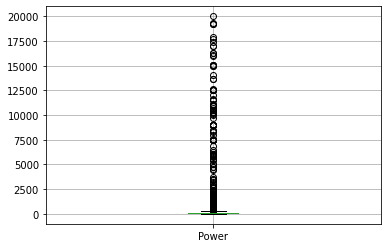

In [18]:
data.boxplot('Power')
plt.show()

In [19]:
# % of invalid values
data.query('Power > 2000').shape[0] / data.shape[0]

0.0003386300720435478

Maximum registered vehicle horsepower in horsepower - 2000 hp. Let's delete all lines containing incorrect values.

In [20]:
data = data.loc[data['Power'] <= 2000]

In [21]:
# % of values equal to 0
data.query('Power == 0').shape[0] / data.shape[0]

0.11355007353584626

The power of the car also cannot be equal to 0 hp. However, there are many rows with such values - it is undesirable to delete them. Let's replace 0 with the column median.

In [22]:
data.query('Power == 0')['Price'].median() 

1050.0

In [23]:
data.query('Power != 0 and Power < 50')['Price'].median()

800.0

In [24]:
data['Power'] = data['Power'].replace(0, int(data['Power'].median()))

Registration year and month:

In [25]:
data['RegistrationYear'].describe()

count    354249.000000
mean       2004.223636
std          90.087089
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

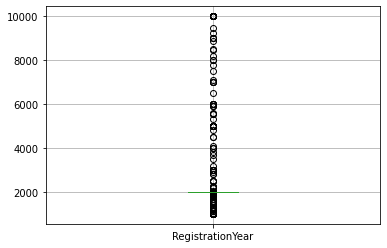

In [26]:
data.boxplot('RegistrationYear')
plt.show()

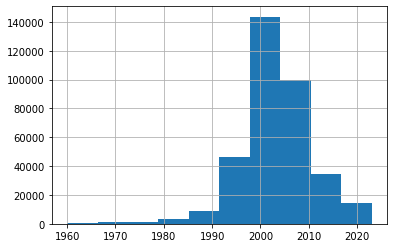

In [27]:
data['RegistrationYear'].hist(range=(1960, 2023))
plt.show()

In [28]:
# % of valid values
data.query('RegistrationYear >= 1960 and RegistrationYear <= 2023').shape[0] / data.shape[0]

0.9985179915821922

All values in the column with year of enrollment less than 1960 and greater than 2023 are outliers and represent less than 1% of the entire dataframe. Let's exclude them.

In [29]:
data = data.loc[(data['RegistrationYear'] >= 1960)&(data['RegistrationYear'] <= 2023)]

In [30]:
# rows where the uploading year is less than the registration year
data['YearCrawled'] = pd.to_datetime(data['DateCrawled']).dt.year
data.query('YearCrawled < RegistrationYear')['Price'].count() / data.shape[0]

0.040754938878899936

In 4% of rows, the upload of the questionnaire occurred before the vehicle registration. That's a mistake. Let's delete these rows.

In [31]:
data = data.loc[data['YearCrawled'] >= data['RegistrationYear']]

The columns related to the time of uploading questionnaires will not be needed in the future, so they can be deleted.

In [32]:
data.drop(columns=['YearCrawled', 'DateCrawled'], inplace=True)

Unlike the year of registration, the month does not particularly affect the value of the car, as confirmed by the correlation coefficient. \
The column can be deleted.

In [33]:
# correlation coefficient
data.corr()['Price']

Price                1.000000
RegistrationYear     0.453736
Power                0.412029
Kilometer           -0.337742
RegistrationMonth    0.107361
Name: Price, dtype: float64

In [34]:
data.drop(columns='RegistrationMonth', inplace=True)

Additionally, we consider anomalies in the target feature to ensure that the model learns only from the correct values.

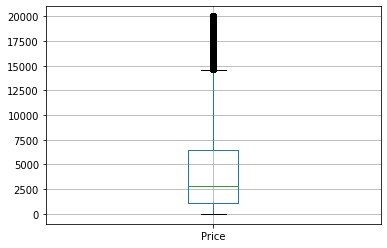

In [35]:
data.boxplot('Price')
plt.show()

In [36]:
data['Price'].describe()

count    339308.000000
mean       4470.230941
std        4543.893425
min           0.000000
25%        1100.000000
50%        2799.000000
75%        6500.000000
max       20000.000000
Name: Price, dtype: float64

In [37]:
data.query('Price == 0')['Price'].count()

9933

In [38]:
data.query('Price < 10')['Price'].count()

11098

The upper limits of car prices are within realistic limits. However, it is unlikely that anyone would give a car away for free or for less than 10 euros. Since the incorrect values have been identified in the target feature, it would be wrong to fill them with some calculated value, as it may strongly affect the importance of the features and the correctness of the predictions. Let's delete the incorrect rows.

In [39]:
data = data.loc[data['Price'] >= 10]

In [40]:
# initial preprocessing result
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 328210 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             328210 non-null  int64 
 1   VehicleType       328210 non-null  object
 2   RegistrationYear  328210 non-null  int64 
 3   Gearbox           328210 non-null  object
 4   Power             328210 non-null  int64 
 5   Kilometer         328210 non-null  int64 
 6   FuelType          328210 non-null  object
 7   Brand             328210 non-null  object
 8   Repaired          328210 non-null  object
dtypes: int64(4), object(5)
memory usage: 25.0+ MB


Thus, the number of features was reduced to 7, 3 of which are numeric. All gaps in the categorical columns were filled, mainly by using a blank value ("other" or "unknown"), all abnormal values in the numeric columns were eliminated or corrected. At the same time, the volume of the dataset was mostly preserved.

Further preprocessing - scaling of numeric attributes, coding of categorical attributes will be conveniently used as part of the Pipeline.

In [41]:
# train and test sets
features = data.drop(columns='Price')
target = data['Price']

features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25, random_state=123)

<a id='models'></a>
## Model selection

Let's compare 2 most frequently used machine learning algorithms - *Random Forest* and *Gradient Busting*. We will select parameters using GridSearchCV. To encode categorical attributes, we will choose the *Label encoding* method, which does not increase the dataset size.

In [42]:
# categorical columns
numeric = ['RegistrationYear', 'Power', 'Kilometer']
categorical = ['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'Repaired']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric),
        ('cat', OrdinalEncoder(), categorical)])

In [43]:
# del data

In [44]:
%%time
# Random Forest

params = {'rf__n_estimators': [50, 80],
          'rf__max_depth': [5, 8]}

pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor),   
    ('rf', RandomForestRegressor())])  

grid = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', cv=3, n_jobs=4)
grid.fit(features_train, target_train)

print("Лучшие параметры: {}".format(grid.best_params_))
print("Лучший результат (RMSE): {:.2f}".format(-grid.best_score_))
print('Временные результаты для лучшей модели:')
display(pd.DataFrame(grid.cv_results_).query('rank_test_score == 1')[['mean_fit_time', 'mean_score_time']])

Лучшие параметры: {'rf__max_depth': 8, 'rf__n_estimators': 80}
Лучший результат (RMSE): 2063.50
Временные результаты для лучшей модели:


,mean_fit_time,mean_score_time
3,43.482743,0.964603


CPU times: user 18.9 s, sys: 235 ms, total: 19.1 s
Wall time: 2min 43s


In [45]:
%%time
# Gradient boosting

params = {'lgbm__n_estimators': [50, 80],
          'lgbm__max_depth': [5, 8], 
          'lgbm__learning_rate': [0.5, 1]}

pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor),  
    ('lgbm', LGBMRegressor())])       

grid = GridSearchCV(pipe, param_grid=params, scoring='neg_root_mean_squared_error', cv=5, n_jobs=4)
grid.fit(features_train, target_train)

print("Лучшие параметры: {}".format(grid.best_params_))
print("Лучший результат (RMSE): {:.2f}".format(-grid.best_score_))
print('Временные результаты для лучшей модели:')
display(pd.DataFrame(grid.cv_results_).query('rank_test_score == 1')[['mean_fit_time', 'mean_score_time']])

Лучшие параметры: {'lgbm__learning_rate': 0.5, 'lgbm__max_depth': 8, 'lgbm__n_estimators': 80}
Лучший результат (RMSE): 1711.53
Временные результаты для лучшей модели:


,mean_fit_time,mean_score_time
3,5.812782,0.968252


CPU times: user 1min 21s, sys: 971 ms, total: 1min 22s
Wall time: 2min 28s


Gradient boosting performed the best judging from the RMSE and time metrics. The training time of the gradient boosting model is much shorter than the training time of the random forest model. The prediction time, on the other hand, is approximately the same.

<a id='test'></a>
## Final testing and results

We test the gradient boosting model with optimized hyperparameters on the test set:

In [46]:
%%time
pipe = Pipeline(steps=[
    ('preprocessor',  preprocessor),
    ('lgbm', LGBMRegressor(n_estimators=80, max_depth=8, learning_rate=0.5))])

pipe.fit(features_train, target_train)
predictions = pipe.predict(features_test)

rmse = mean_squared_error(target_test, predictions, squared=False)
print("RMSE бустинга на тестовом наборе: {:.2f}".format(rmse))

RMSE бустинга на тестовом наборе: 1705.66
CPU times: user 1min 10s, sys: 597 ms, total: 1min 10s
Wall time: 1min 11s


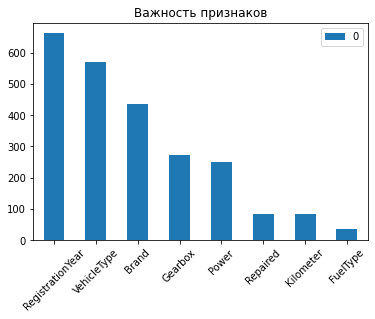

In [47]:
# feature importance
importances = pipe.named_steps['lgbm'].feature_importances_
feature_importances = pd.DataFrame(pd.Series(importances, index=features_test.columns))
feature_importances.sort_values(by=0, ascending=False).plot(kind='bar', title='Важность признаков')
plt.xticks(rotation=45)
plt.show()

The biggest influence on the price of a car is the year of registration, car body type and brand name.

**Conclusion:**
This project was to develop a machine learning model to predict the market value of a car based on its features. In the preprocessing stage, the data were cleaned: outliers and anomalous values were removed or corrected, some features were removed that did not significantly affect the target variable. Immediately before training, numerical features were scaled and categorical features were coded using the OHE method (these steps were included in the training payplan).

The most commonly used machine learning algorithms, *random forest* and *gradient boosting*, were chosen for comparison. Since the dataset under study turned out to be quite large in volume, only the most significant hyperparameters within a limited range were selected for each algorithm. The metric for assessing the quality of the models was RMSE. 

Even under these conditions, **gradient boosting performed better**, both in terms of speed of model training and hyperparameter selection, and in terms of the quality of the resulting model. The lowest RMSE value for the finalized gradient boosting model was 1705.66 on the test set (1711.53 on the training set). The model training time is about 5 seconds, the time of fitting hyperparameters (number of trees, maximum tree depth + learning rate) is about 2 min.